In [3]:
!pip install geopandas shapely

In [1]:
import geopandas as gpd
from shapely.geometry import Point

# 加载饮料店数据
drink_shops_df = gpd.read_file('./merged_data0301.csv')
drink_shops_gdf = gpd.GeoDataFrame(
    drink_shops_df, 
    geometry=[Point(xy) for xy in zip(drink_shops_df.longitude, drink_shops_df.latitude)]
)

# 加载学校数据
schools_df = gpd.read_file('./雙北學校.csv')
schools_gdf = gpd.GeoDataFrame(
    schools_df, 
    geometry=[Point(xy) for xy in zip(schools_df.longitude, schools_df.latitude)]
)

# 设置坐标参考系统为 WGS84
drink_shops_gdf.crs = "epsg:4326" # epsg:3826
schools_gdf.crs = "epsg:4326"

drink_shops_df

,name,star,comment,class,address,latitude,longitude,geometry
0,果滋味綜合飲料店,4.9,17,冰品飲料店,新北市三峽區大德路39號1樓,24.9429943,121.3770984,None
1,可不可熟成紅茶-三峽北大店,3.9,191,冰品飲料店,新北市三峽區學成路229號,24.9425087,121.374965,None
2,茶聚CHAGE三峽和平店｜香片領導品牌＿新北手搖飲料店外帶外送加盟推薦│在地美食飲料茶飲創業加盟,4.7,354,冰品飲料店,新北市三峽區和平街107號,24.9382843,121.3703329,None
3,50嵐 三峽北大店,4.3,101,冰品飲料店,新北市三峽區大學路129號1樓,24.9436023,121.3745389,None
4,五桐號WooTEA 三峽北大店,3.7,62,冰品飲料店,新北市三峽區國學街39號,24.942509,121.3726773,None
...,...,...,...,...,...,...,...,...
4738,津之荺茶飲,5,10,茶藝館,新北市鶯歌區尖山埔路64-2號陶瓷街11號對面,24.9511221,121.3484231,None
4739,東霖茶業 Tunlin Tea,4.9,34,茶葉店,新北市鶯歌區育英街63號,24.9524784,121.3471926,None
4740,胖茶鶯歌建國店/鶯歌飲料推薦/鶯歌特色飲料/鶯歌必喝/鮮萃黑茶/黑奶茶/仙草凍拿鐵,4.5,36,珍珠奶茶,新北市鶯歌區建國路127號,24.9538797,121.3517273,None
4741,清心福全鶯歌中正店,3.7,72,無酒精飲料店,新北市鶯歌區中正三路83號,24.9410339,121.3385677,None


In [2]:
# 转换坐标系统到 Web Mercator (epsg:3857) 以计算以米为单位的距离
drink_shops_gdf = drink_shops_gdf.to_crs(epsg=3826)
schools_gdf = schools_gdf.to_crs(epsg=3826)

# 为每个饮料店创建方圆 1 公里的缓冲区
drink_shops_gdf['buffer'] = drink_shops_gdf.geometry.buffer(1000, resolution=99)  # 1000 米



In [3]:
# from geopandas.tools import sjoin

# # 将缓冲区作为新的 GeoDataFrame
# buffers_gdf = gpd.GeoDataFrame(geometry=drink_shops_gdf['buffer'])
# buffers_gdf.crs = drink_shops_gdf.crs

# # 使用空间连接找出位于饮料店 1 公里范围内的学校
# joined_gdf = sjoin(buffers_gdf, schools_gdf, how="inner", predicate='contains')

# print(joined_gdf.columns)

# # 统计每个饮料店范围内的学校数量
# school_counts = joined_gdf.groupby('index_left').size()

# print(school_counts)


In [4]:
# 假设这是添加标识符的步骤
drink_shops_gdf['shop_id'] = range(len(drink_shops_gdf))

# 创建缓冲区 GeoDataFrame，并包括 shop_id
buffers_gdf = gpd.GeoDataFrame(drink_shops_gdf[['shop_id', 'geometry']].copy())
buffers_gdf['geometry'] = buffers_gdf.geometry.buffer(1000)  # 创建缓冲区


In [7]:
# 执行空间连接
joined_gdf = sjoin(buffers_gdf, schools_gdf, how="inner", predicate='contains')

# 统计每个缓冲区（即每个饮料店）内的学校数量
school_counts = joined_gdf.groupby('shop_id').size()

# 为了确保即使是点数为 0 的多边形也能被统计
# 我们需要将计数结果与原始的多边形 GeoDataFrame 进行合并
buffers_gdf['points_count'] = buffers_gdf.index.map(school_counts).fillna(0)

# print(school_counts)

buffers_gdf['points_count']

0       6.0
1       5.0
2       6.0
3       5.0
4       6.0
       ... 
4738    2.0
4739    3.0
4740    2.0
4741    3.0
4742    2.0
Name: points_count, Length: 4743, dtype: float64

In [6]:
from geopandas.tools import sjoin

In [10]:
import pandas as pd
#顯示所有列
pd.set_option('display.max_columns', None)
#顯示所有行
pd.set_option('display.max_rows', None)

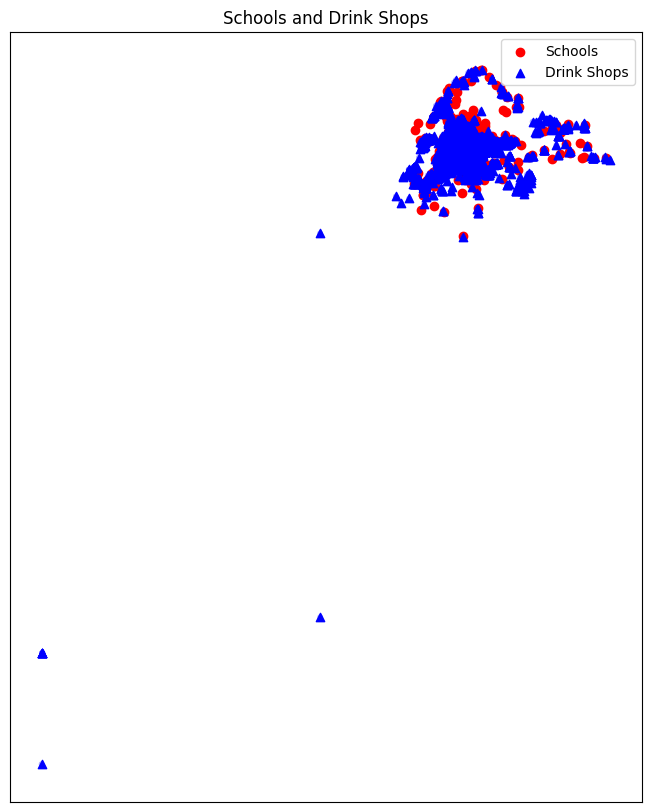

In [49]:
import matplotlib.pyplot as plt

# 设置绘图
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制学校的位置，用红色表示
schools_gdf.plot(ax=ax, color='red', marker='o', label='Schools')

# 绘制饮料店的位置，用蓝色表示
drink_shops_gdf.plot(ax=ax, color='blue', marker='^', label='Drink Shops')

# 可选：绘制饮料店的缓冲区（1公里范围）
# 假设 drink_shops_gdf 已经有了 'buffer' 这个列
buffers_gdf = gpd.GeoDataFrame(geometry=drink_shops_gdf['buffer'])
buffers_gdf.plot(ax=ax, color='blue', alpha=0.3)

# 设置图例
ax.legend()

# 设置标题
ax.set_title('Schools and Drink Shops')

# 移除 x 和 y 轴的标签
ax.set_xticks([])
ax.set_yticks([])

# 显示图形
plt.show()
